## Changing the free energy of repressor binding

Required packages:

In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

fdir = '../data/'
out_fdir = '../plots/fig7/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1.1 Changing repressor binding energy

In this notebook, we change the free energy of repressor binding and examine how that changes the information footprint. The free energy of repressor binding is given by
$$
\begin{align}
    F_R = \Delta \varepsilon_\mathrm{rd} - k_BT \ln \frac{R}{N_\mathrm{NS}}.
\end{align}
$$

The first way to change the free energy is to change the binding energy $\Delta \varepsilon_\mathrm{rd}$, which we do below.

For each binding energy, we simulate 20 synthetic datasets in order to observe the average effects. To save computational time, we first generate 20 mutant libraries beforehand using the function `mutations_rand` and we reuse the mutant libraries for each given binding energy.

In [6]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

We specify the usual parameters needed for a simple repression thermodynamic model and the range of repressor binding energies that we would like to examine. For each repressor binding energy, we build synthetic datasets for each of the 100 pre-generated synthetic dataset and we keep track of the average mutual information at the RNAP binding site and the repressor binding site.

In [7]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
l_er_wt = np.arange(-20, 0, 1)

rnap_signal = []
rep_signal = []
for er_wt in l_er_wt:
    rnap = []
    rep = []
    for i in range(len(mutant_bank)):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                preset_mutants=mutant_bank[i],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    rnap_signal.append(np.mean(rnap))
    rep_signal.append(np.mean(rep))

Plotting the average mutual information at the RNAP binding site and the repressor binding site against the repressor binding energy.

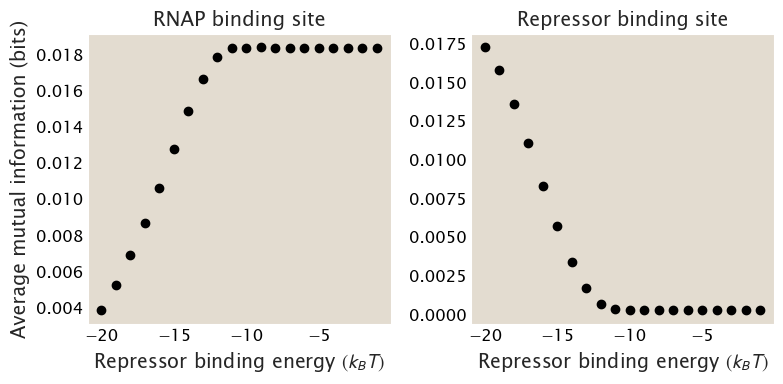

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_er_wt, rnap_signal, color='k')
ax1.set_xlabel('Repressor binding energy ' + r'$(k_BT)$', fontsize=14)
ax1.set_ylabel('Average mutual information (bits)', fontsize=14)
ax1.set_title('RNAP binding site')
#ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_er_wt, rep_signal, color='k')
ax2.set_xlabel('Repressor binding energy ' + r'$(k_BT)$', fontsize=14)
ax2.set_title('Repressor binding site', fontsize=14)
#ax2.set_yticks([0, 0.005, 0.01, 0.015])

plt.tight_layout()
plt.savefig(out_fdir + 'repressor_binding_energy.pdf')

### 1.2 Example information footprint with different repressor binding energy

Example information footprint where the repressor binding energy is set to $-10\ k_BT$

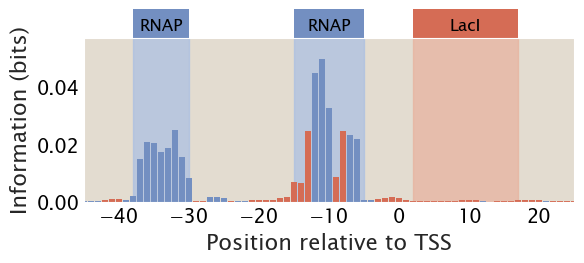

In [9]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'repressor_binding_energy_fp1.pdf')

Example information footprint where the repressor binding energy is set to $-20\ k_BT$

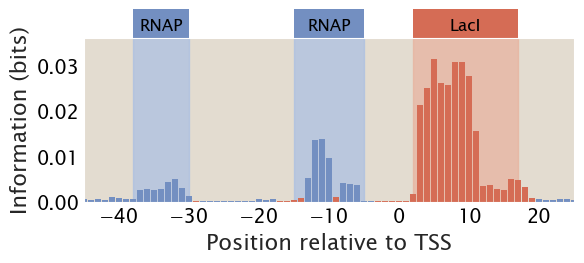

In [10]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -20

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'repressor_binding_energy_fp2.pdf')

### 2.1 Changing repressor copy number

The second way to change the free energy of repressor binding is to change the copy number of the repressor. Below, we specify a range of repressor copy number from 0 to 1000, simulate 20 synthetic datasets and keep track of the average mutual information at the RNAP binding site and the repressor binding site.

In [11]:
n_NS = len(genome)
n_p = 5000
ep_wt = -5
er_wt = -15

l_n_r = np.arange(0, 1001, 10)

rnap_signal = []
rep_signal = []
for n_r in l_n_r:
    rnap = []
    rep = []
    for i in range(len(mutant_bank)):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                preset_mutants=mutant_bank[i],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    rnap_signal.append(np.mean(rnap))
    rep_signal.append(np.mean(rep))

Next, we plot the average mutual information at the RNAP binding site and at the repressor binding site against repressor copy number.

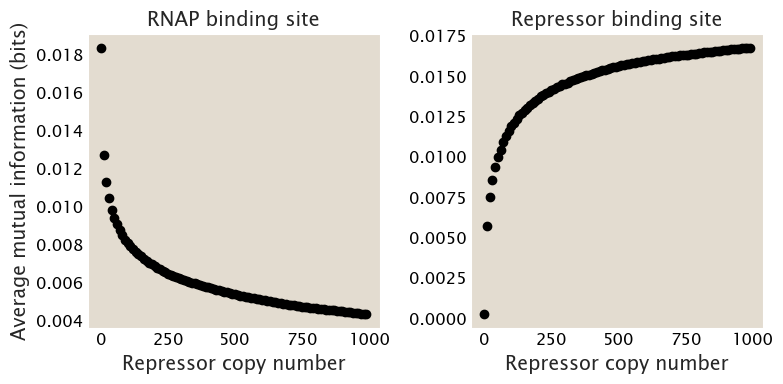

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_n_r, rnap_signal, color='k')
ax1.set_xlabel('Repressor copy number', fontsize=14)
ax1.set_ylabel('Average mutual information (bits)', fontsize=14)
ax1.set_title('RNAP binding site')
#ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_n_r, rep_signal, color='k')
ax2.set_xlabel('Repressor copy number', fontsize=14)
ax2.set_title('Repressor binding site', fontsize=14)
#ax2.set_yticks([0, 0.005, 0.01, 0.015])

plt.tight_layout()
plt.savefig(out_fdir + 'repressor_copy_number.pdf', dpi=300)

### 2.2 Example information footprint with different repressor copy number

Example information footprint where the repressor copy number is set to 1

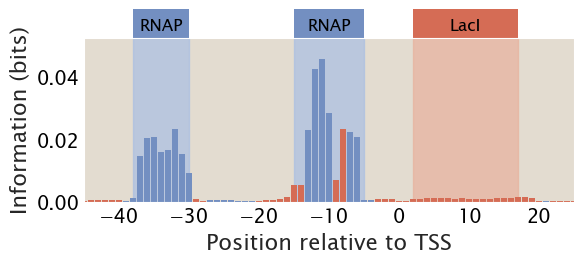

In [13]:
n_NS = len(genome)
n_p = 5000
n_r = 1
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'repressor_copy_number_fp1.pdf')

Example information footprint where the repressor copy number is set to 500

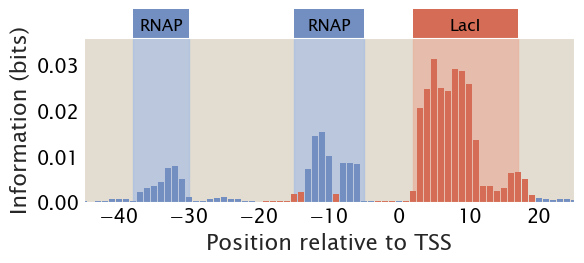

In [14]:
n_NS = len(genome)
n_p = 5000
n_r = 500
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'repressor_copy_number_fp2.pdf')